# Detect German traffic signs

In this project I will create a model which can classify the type of traffic sign from an image.

[Here](https://en.wikipedia.org/wiki/Road_signs_in_Germany) you can see some examples taken from wikipedia.

This dataset contains only 43 classes, which are the most common, so this means it will not work for other german traffic signs which are not available.
At the end of this notebook there is also a snippet code which can be used to detect traffic signs from URLs!
This will be usefull to see how the model behaves with unseen data.

Here you can download the [Dataset](https://bitbucket.org/jadslim/german-traffic-signs)

First of all we will import some necessary libraries for this project, remember to install the same version of each library. The detailed informations are in Requirements.txt file.

In [1]:
import numpy as np
np.random.seed(123)

import tensorflow as tf
tf.set_random_seed(123)

# this is needed for my current hardware configuration, maybe in your case it will not be necessary
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import random
import cv2
import os

# Data Exploration

In this part of the notebook we will load and explore the data, understand its distribution and come out with some ideas which will be usefull for training.

Let's start by loading the data first and checking the number of images.

In [3]:
def load_pickle_data(path):
    """Given a path to a pickle object,
    return images and labels"""
    with open(path, "rb") as F:
        data = pickle.load(F)
    return data["features"], data["labels"]

In [4]:
# make sure the path is correct for your setup, in my case the data is stored on a different HDD
dataset_dir = "/media/ml/Datasets/German-traffic-signs/german-traffic-signs"

In [5]:
X_train, Y_train = load_pickle_data(os.path.join(dataset_dir, "train.p"))
X_val, Y_val = load_pickle_data(os.path.join(dataset_dir, "valid.p"))
X_test, Y_test = load_pickle_data(os.path.join(dataset_dir, "test.p"))

In [6]:
print(f"train: {X_train.shape}\nvalid: {X_val.shape}\ntest: {X_test.shape}")

train: (34799, 32, 32, 3)
valid: (4410, 32, 32, 3)
test: (12630, 32, 32, 3)


Ok so the images are RGB images with size 32x32 pixels and we have ~35000 training images, ~4500 images for validation and ~12500 images for testing.

Just to be safe we have to make sure that the number of images and labels is the same.

In [7]:
assert(X_train.shape[0]==Y_train.shape[0]), "The number of images in the train set doesn't match the number of labels"
assert(X_val.shape[0]==Y_val.shape[0]), "The number of images in the validation set doesn't match the number of labels"
assert(X_test.shape[0]==Y_test.shape[0]), "The number of images in the test set doesn't match the number of labels"

Now we have to import the name of all traffic signs, so it is going to be easier for us to understand the class instead of having only numbers.

In [8]:
data = pd.read_csv(os.path.join(dataset_dir, "signnames.csv"))

Ok, we have loaded all necessary files, so now it is time to visualize some examples from the dataset.
The following code will show 5 random images for each traffic sign class.

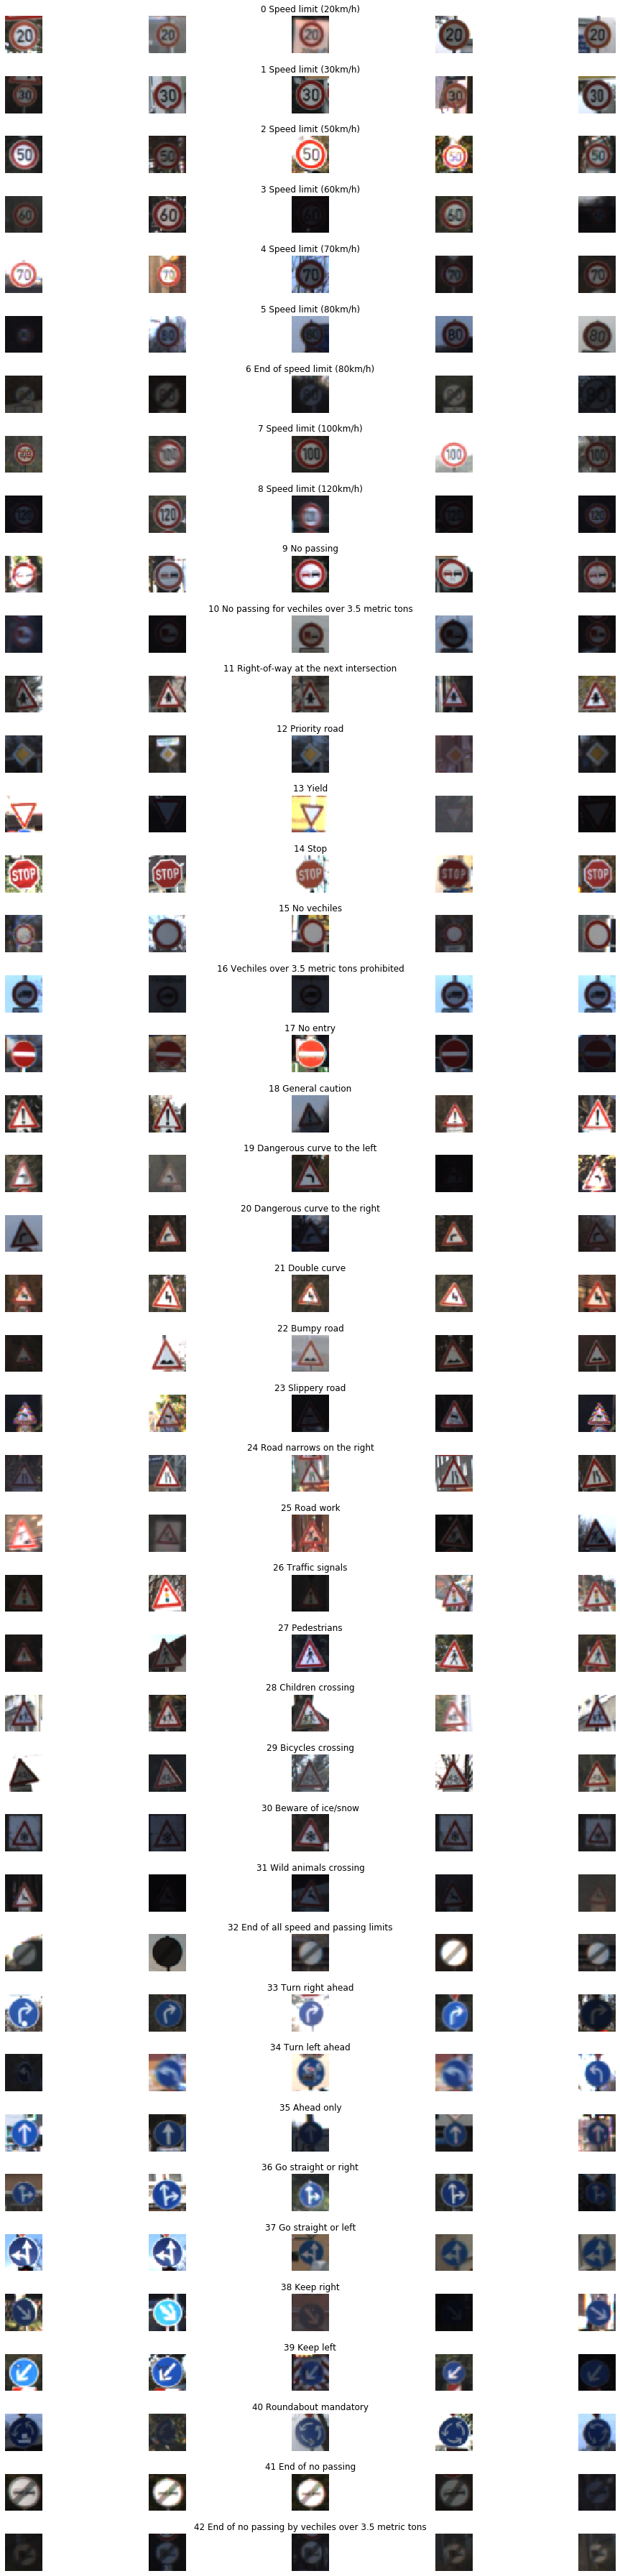

In [9]:
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(14, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        
        # get only the images related to the current class
        x_selected = X_train[Y_train == j]
        max_len = x_selected.shape[0] - 1
        
        # show a random image related to the current class
        axs[j][i].imshow(x_selected[random.randint(0, max_len), :, :])
        axs[j][i].axis("off")
        
        # display the name
        if i == 2:
            axs[j][i].set_title("{} {}".format(j, row['SignName']))

This step is very important to understand how the data looks like.
From the images above we can notice that the data contains traffic sign in many different light conditions.
Another important fact is that the traffic signs are well centered in the image but portions of other traffic signs might be present in the same image (1st example in the class "Speed limit 20km/h").

After seeing how the data looks like, now we have to visualize its distribution.

The code below will show a histogram plot of the number of images per each class.
We will repeat this step for training, validation and testing dataset.

In [10]:
from visualizations.statistics import plot_distribution

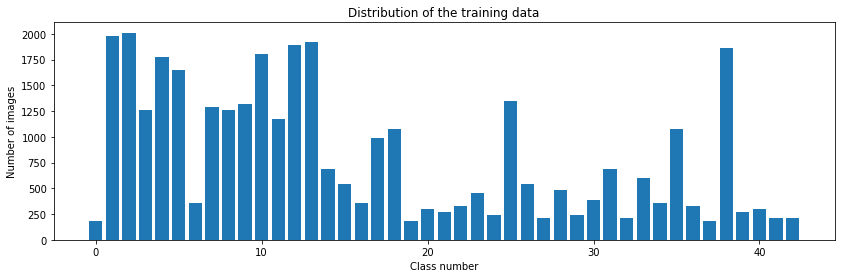

In [11]:
plot_distribution(Y_train, "Distribution of the training data")

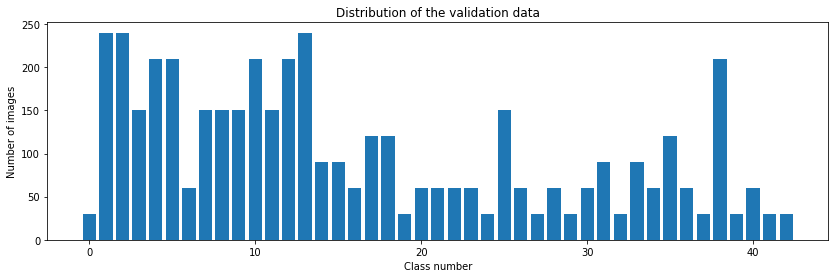

In [12]:
plot_distribution(Y_val, "Distribution of the validation data")

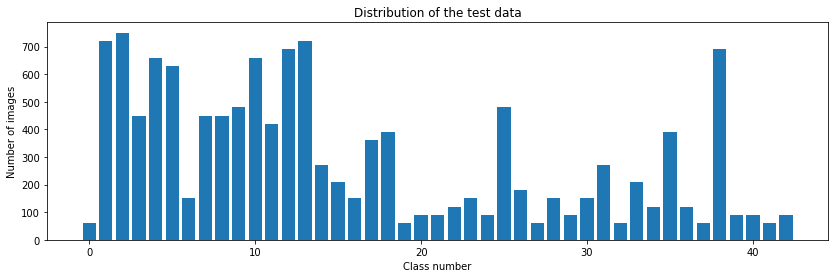

In [13]:
plot_distribution(Y_test, "Distribution of the test data")

We can see that we are dealing with a highly imbalanced dataset, but we can also see that the distribution across all datasets is very similar and this is a helpfull information for us.

# Data Preparation

In this part of the notebook we will manipulate the dataset in order to prepare it for training.
The first thing to do is to combine the validation and training dataset, we will use the test dataset as validation set during training later.
This is necessary because we have very few examples in the training set for some classes, so for this reason we need more data.

In [14]:
X_train = np.concatenate([X_train, X_val], axis=0)
Y_train = np.concatenate([Y_train, Y_val], axis=0)

print(X_train.shape, Y_train.shape)

(39209, 32, 32, 3) (39209,)


There is still something we can do to increase the number of samples.

Some images can be flipped horizontally without causing any problem to recognize the traffic sign.
![example1](doc_images/horizontal_flip1.png)

Some other can be flipped vertically.
![example2](doc_images/vertical_flip.png)

Some other can be flipped vertically, horizontally or both way.
![example3](doc_images/vertical_or_horizontal_flip.png)

Some other can be flipped horizontally and vertically at the same time without causing problems to the traffic sign.
![example4](doc_images/flip_both.png)

Finally other images can be flipped horizontally, but their class will change.
![example5](doc_images/horizontal_flip2.png)

Since we can't flip all images, because it would result into wrong data, we will define a dictionary with actual labels as keys and tuples as values. The first element of the tuple corresponds to the label when images are augmented and the second element refers on which axis the image should be flipped.

In [15]:
# axis = 0 -> vertical flip
# axis = 1 -> horizontal flip
# axis = -1 -> flip both axes
# axis = 2 -> all the above

class_map = {
    1: (1, 0),
    5: (5, 0),
    11: (11, 1),
    # these 2 classes contain already many examples so we will skip them
    # 12: (12, 2),
    # 13: (13, 1),
    15: (15, 2),
    17: (17, 2),
    18: (18, 1),
    19: (20, 1),
    20: (19, 1),
    22: (22, 1),
    26: (26, 1),
    30: (30, 1),
    32: (32, -1),
    33: (34, 1),
    34: (33, 1),
    35: (35, 1),
    36: (37, 1),
    37: (36, 1),
    38: (39, 1),
    39: (38, 1),
    40: (40, -1)
}

In [16]:
# separate the augmented examples in a different variable to ensure the data hasn't been manipulated wrong
x_placeholders = []
y_placeholders = []

# for each label in the class map
for actual_label, (corresponding_label, axis) in class_map.items():
    
    # get indices
    indices = np.where(Y_train==actual_label)[0]
    
    # if axis == 2 then we need to flip multiple times, so we create a tuple
    # in from which we can interate
    axis = (-1, 0, 1) if axis == 2 else (axis, )
    
    for ax in axis:
        # create a lambda function used for mapping the images
        flip = lambda img: cv2.flip(img, ax)

        # flip image and append data to placeholders
        x_placeholders.append(np.array(list(map(flip, X_train[indices].copy()))))
        # append a numpy array with specific value
        y_placeholders.append(np.full(shape=(len(indices),), fill_value=corresponding_label, dtype=np.uint8))

It is always good practice to check if the data we manipulate look still good after augmentation.
For this reason we will now plots some images after the augmentation mentioned above.

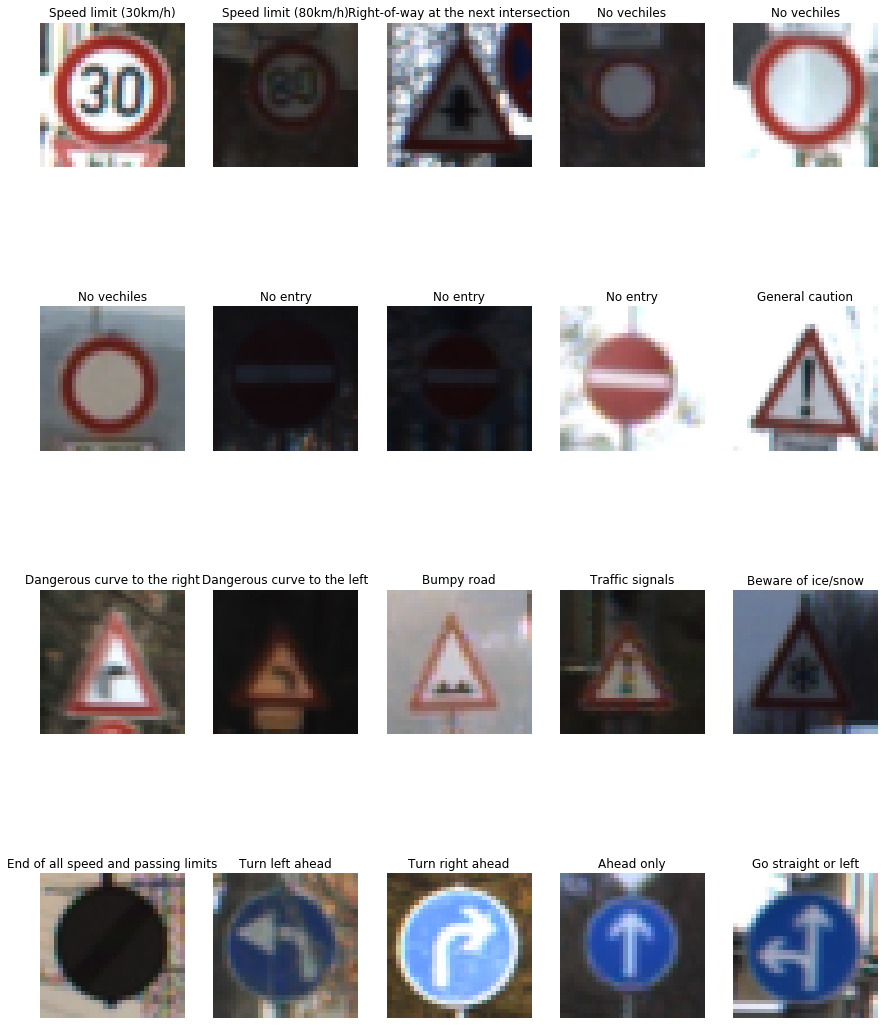

In [17]:
# claculate number of rows for subplots
n_rows = (len(class_map) // 5)
if(len(class_map) % 5):
    n_rows += 1

fig, plots = plt.subplots(n_rows, 5, figsize=(15, len(class_map)))

for i, _ in enumerate(class_map.values()):
    # select a random index
    index = random.randint(0, len(x_placeholders[i]) -1)
    label = y_placeholders[i][index]
    
    # show image and label
    plots[i//5][i%5].imshow(x_placeholders[i][index])
    plots[i//5][i%5].axis("off")
    plots[i//5][i%5].set_title(f"{data['SignName'][label]}")

plt.show()

This images can't be used for testing pourpose of course, so we will put these images only into the training dataset and see how the data distribution per class looks like.

In [18]:
X_train = np.concatenate([X_train] + x_placeholders, axis=0)
Y_train = np.concatenate([Y_train] + y_placeholders, axis=0)

print(X_train.shape, Y_train.shape)

(58918, 32, 32, 3) (58918,)


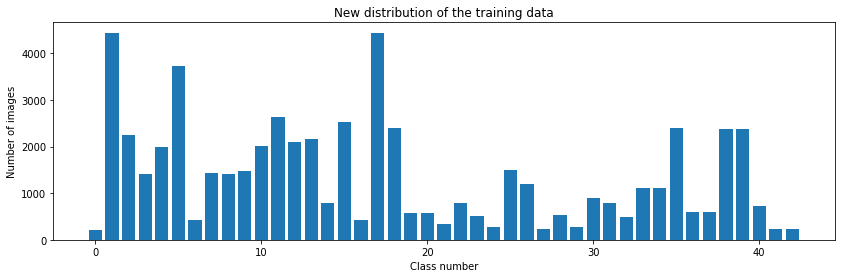

In [19]:
plot_distribution(Y_train, "New distribution of the training data")

It helped but it is still very imbalanced, there are classes with far too many examples.

To reduce this problem we will use an useful python package called imbalanced-learn, which is designed specifically for data balancing. After several trial I have found out that thresholding the majority classes without upsampling the minotity ones resulted in the best performance.

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from utils.utils import count_unique_elements

In [21]:
shape = X_train.shape
flatten = (shape[0], shape[1] * shape[2] * shape[3])
X_train = np.reshape(X_train, flatten)

# undersample some classes to a maximum threshold of 1500 samples
under = {class_: 1500 if count > 1500 else count for class_, count in count_unique_elements(Y_train).items()}

ru = RandomUnderSampler(sampling_strategy=under)
X_train, Y_train = ru.fit_resample(X_train, Y_train)

X_train = np.reshape(X_train, (-1, 32, 32, 3))

### Let's see now the effect

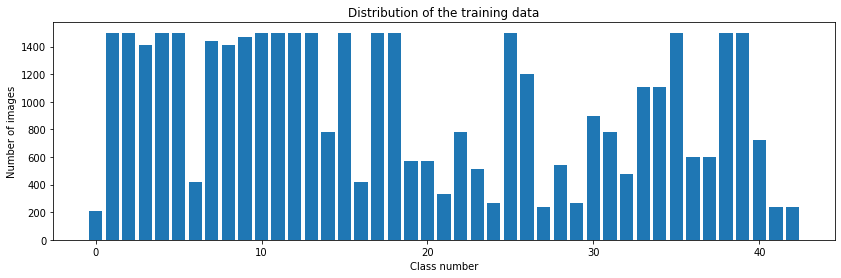

In [22]:
plot_distribution(Y_train, "Distribution of the training data")

In [23]:
print(f"Total number of training images after balancing: {X_train.shape[0]}")

Total number of training images after balancing: 42118


This looks much better! Oversampling the minority class in this case I saw it doesn't help so we can be satisfied.

We still didn't modify any image so far, now it is time to preprocess these images to help the Neural Network learn better.

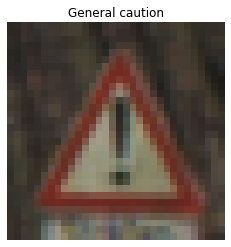

In [24]:
# Show a random image before preprocessing
index = random.randint(0, X_train.shape[0] - 1)
plt.imshow(X_train[index])
plt.axis("off")
plt.title(data["SignName"][Y_train[index]])
plt.show()

Preprocessing technique.

Now the image will be preprocessed and out of one input image we will create 2 output images: one rgb and one gray scale.

The following steps will be applied to preprocessing:

    On rgb image:
        applies histogram equalization on each channel and then stack the channels back together.

    On gray scale image:
        the image is first converted to grayscale, then Histogram Equalization is applied.

    The image is also normalized by dividing it by 255, this will keep each pixel in the value between 0 and 1.

In [25]:
from utils.utils import preprocess_image

In [26]:
# lambda function used for grayscale images
map_to_gray = lambda x: preprocess_image(x, convert_to_gray=True)

# applying preprocessing to the datasets
X_train = [np.array(list(map(preprocess_image, X_train))), np.array(list(map(map_to_gray, X_train)))]
X_test = [np.array(list(map(preprocess_image, X_test))), np.array(list(map(map_to_gray, X_test)))]

In [27]:
rgb_train, gray_train = X_train
rgb_test, gray_test = X_test

We can see in the code below how the image looks like after preprocessing.

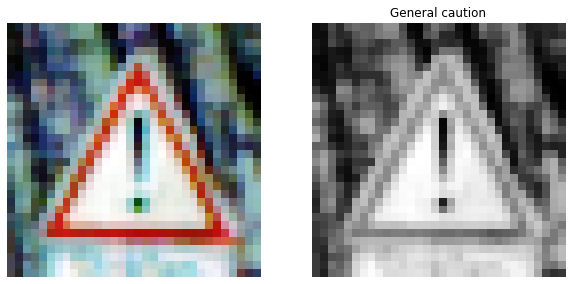

In [28]:
fig, plots = plt.subplots(1, 2, figsize=(10, 5))

plots[0].imshow(rgb_train[index].reshape(32,32, 3))
plots[0].axis("off")
plots[1].imshow(gray_train[index].reshape(32,32), cmap="gray")
plots[1].axis("off")
plt.title(data["SignName"][Y_train[index]])
plt.show()

The final DATA PREPARATION step is augmentation, for this we will use the ImageDataGenerator class from Keras which will augment the data 'on the fly'.

In [29]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [30]:
# data augmentation for rgb images
datagen = ImageDataGenerator(width_shift_range=0.25,
                             height_shift_range=0.25,
                             zoom_range=0.3,
                             shear_range=0.1,
                             rotation_range=10)

datagen.fit(rgb_train)

# data augmentation for gray scale images
datagen_gray = ImageDataGenerator(width_shift_range=0.25,
                                  height_shift_range=0.25,
                                  zoom_range=0.3,
                                  shear_range=0.1,
                                  rotation_range=10)

datagen_gray.fit(gray_train)

In the code cell below we can see some images after augmentation.

Index: 33192: Turn right ahead


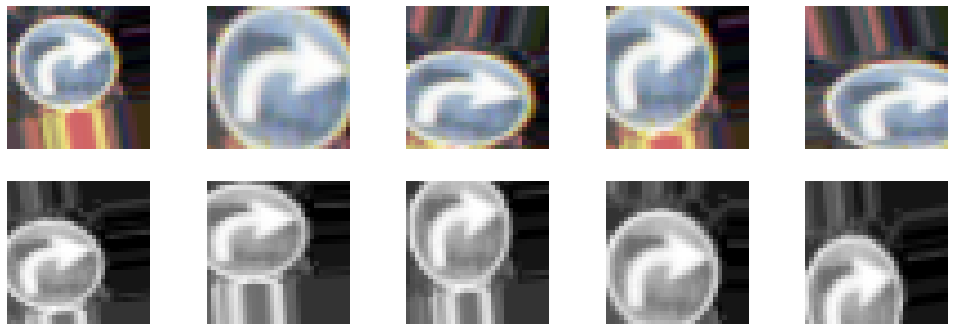

In [31]:
n = np.random.randint(0, X_train[0].shape[0] - 2)
print(f"Index: {n}: {data['SignName'][Y_train[n]]}")

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
fig.tight_layout()

# rgb augmentation
for i, image in enumerate(datagen.flow(rgb_train[n:n+1], batch_size=1)):
    if i >= 5:
        break
    axs[0][i%5].imshow(image.reshape(32, 32, 3))
    axs[0][i%5].axis("off")

# gray scale images
for i, image in enumerate(datagen_gray.flow(gray_train[n:n+1], batch_size=1)):
    if i >= 5:
        break
    axs[1][i%5].imshow(image.reshape(32, 32), cmap='gray')
    axs[1][i%5].axis("off")

Now we have to convert the labels to One hot encoded labels to be able to train the classifier.

In [32]:
from tensorflow.python.keras.utils import to_categorical

In [33]:
Y_train = to_categorical(Y_train, 43)
Y_test = to_categorical(Y_test, 43)

The final step of DATA PREPARATION is label smoothing, this helps against overfitting. A detailed description of how it works can be found [here](https://arxiv.org/abs/1906.02629).

In [34]:
from utils.utils import label_smoothing

In [35]:
Y_train = label_smoothing(Y_train)
Y_test = label_smoothing(Y_test)

# Training

First step is to create 3 models, you might wonder why 3 instead of 1? The answer is that it is better to rely on more than 1 output to make the prediction, this is the reason why we created a dataset of rgb images and one of gray scale ones.

List of models:

rgb_model  -> the main model

gray_model -> model used for redundancy using a different dataset (gray scale images instead of rgb)

foc_model  -> this model uses [Focal loss](https://arxiv.org/abs/1708.02002) to pay more attention on missclassified images

## Model Architecture (same for all 3 models)

![model](Model.png)

In [36]:
from models.get_models import efficient_model
from losses.custom_losses import focal_loss

In [42]:
rgb_model = efficient_model(filters=64, input_shape=(32, 32, 3), regularizers=(1e-5, 1e-4), prefix="rgb")
#print(rgb_model.summary())

In [43]:
gray_model = efficient_model(filters=64, input_shape=(32, 32, 1), regularizers=(2e-5, 2e-4), prefix="gray")
#print(gray_model.summary())

In [44]:
foc_model = efficient_model(filters=64, input_shape=(32, 32, 3), regularizers=(1e-5, 1e-4), prefix="foc",
                            loss=focal_loss(gamma=2., alpha=1.))
#print(foc_model.summary())

Now it is time to train train all 3 models indipendently.

The first training part (fit_generator) of each model is used to speed up training first step.

The second part takes care of finding the best performance, this is why there are 700 epochs and the number of steps per epoch is only 8. The idea here is to check the performance on the validation set every 8 steps to be sure that we achieve the maximum score on each model.

In [45]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [48]:
# to avoid duplicates we create a function for the callbacks
def get_callbacks(prefix):
    callbacks =[
        ModelCheckpoint(filepath=f'saved_models/{prefix}_best_weights_acc.hdf5', mode="max",
                        verbose=1, save_best_only=True, monitor='val_acc'),
        ReduceLROnPlateau(patience=50, monitor="val_acc", verbose=1,
                          factor=0.5, min_lr=5e-6, mode="max")
    ]
    return callbacks

batch_size = 128

# # training rgb model
print("Start training the rgb model...")
rgb_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size), verbose=0,
                        steps_per_epoch=rgb_train.shape[0] // batch_size * 10, epochs=1, shuffle=True)
rgb_history = rgb_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size),
                                      steps_per_epoch=rgb_train.shape[0] // batch_size // 40, epochs=700, 
                                      validation_data=(rgb_test, Y_test), verbose=0,
                                      shuffle=True, callbacks=get_callbacks("rgb"))

# training gray scale model
print("Start training the gray scale model...")
gray_model.fit_generator(datagen_gray.flow(gray_train, Y_train, batch_size=batch_size), verbose=0,
                         steps_per_epoch=gray_train.shape[0] // batch_size * 10, epochs=1, shuffle=True)
gray_history = gray_model.fit_generator(datagen_gray.flow(gray_train, Y_train, batch_size=batch_size),
                                        steps_per_epoch=gray_train.shape[0] // batch_size // 40, epochs=700, 
                                        validation_data=(gray_test, Y_test), verbose=0,
                                        shuffle=True, callbacks=get_callbacks("gray"))

# training foc model
print("Start training the foc model...")
foc_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size), verbose=0,
                        steps_per_epoch=rgb_train.shape[0] // batch_size * 10, epochs=1, shuffle=True)
foc_history = foc_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size),
                                      steps_per_epoch=rgb_train.shape[0] // batch_size // 40, epochs=700, 
                                      validation_data=(rgb_test, Y_test), verbose=0,
                                      shuffle=True, callbacks=get_callbacks("foc"))

Below are the results of the training process.

The gap between train and validation might seem much at first, but if you look at the scale you will see that the model is not overfitting much.

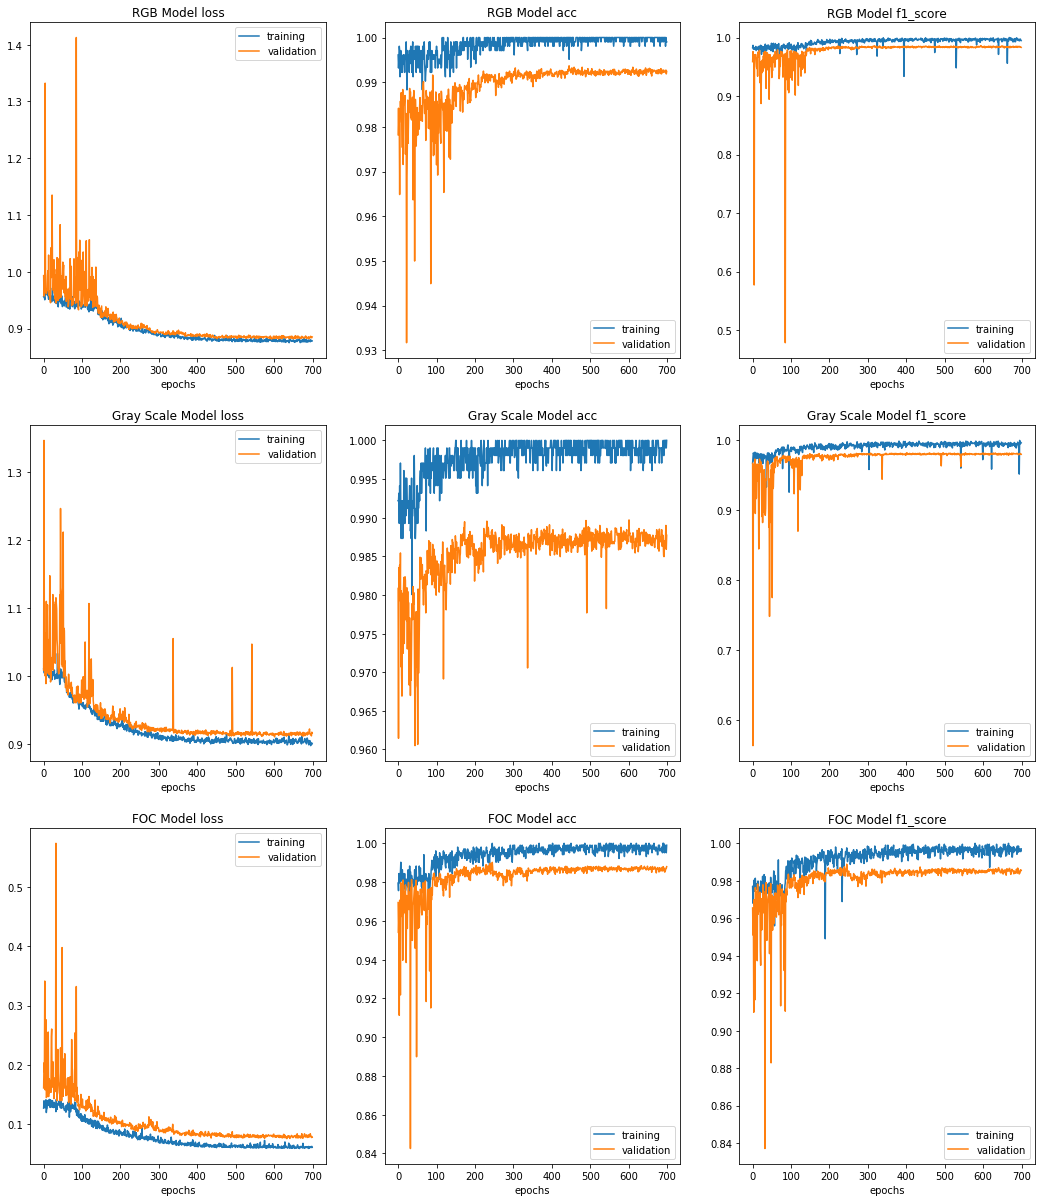

In [47]:
fig, axs = plt.subplots(3, 3, figsize=(18, 21))

for i, name in enumerate(["loss", "acc", "f1_score"]):
    # rgb model history
    axs[0][i].plot(rgb_history.history[name])
    axs[0][i].plot(rgb_history.history[f"val_{name}"])
    axs[0][i].legend(["training", "validation"])
    axs[0][i].set_title(f"RGB Model {name}")
    axs[0][i].set_xlabel("epochs")
    
    # gray scale model history
    axs[1][i].plot(gray_history.history[name])
    axs[1][i].plot(gray_history.history[f"val_{name}"])
    axs[1][i].legend(["training", "validation"])
    axs[1][i].set_title(f"Gray Scale Model {name}")
    axs[1][i].set_xlabel("epochs")
    
    # foc model history
    axs[2][i].plot(foc_history.history[name])
    axs[2][i].plot(foc_history.history[f"val_{name}"])
    axs[2][i].legend(["training", "validation"])
    axs[2][i].set_title(f"FOC Model {name}")
    axs[2][i].set_xlabel("epochs")

plt.show()

Here we load the best weights of each model and check its performance.

As you can see the F1 score of the model using focal loss is much higher than the other 2 models.

In [49]:
rgb_model.load_weights('saved_models/rgb_best_weights_acc.hdf5')
score = rgb_model.evaluate(rgb_test, Y_test, verbose=0)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}\nTest F1_score: {score[2]}")

Test Score: 0.8778088516973827
Test Accuracy: 0.994536817073822
Test F1_score: 0.9846121668815613


In [50]:
gray_model.load_weights('saved_models/gray_best_weights_acc.hdf5')
score = gray_model.evaluate(gray_test, Y_test, verbose=0)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}\nTest F1_score: {score[2]}")

Test Score: 0.9056553415145935
Test Accuracy: 0.990182101726532
Test F1_score: 0.9813865423202515


In [51]:
foc_model.load_weights('saved_models/foc_best_weights_acc.hdf5')
score = foc_model.evaluate(rgb_test, Y_test, verbose=0)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}\nTest F1_score: {score[2]}")

Test Score: 0.07831641136420123
Test Accuracy: 0.9930324554443359
Test F1_score: 0.9906774759292603


# Final Results

Now we will combine the output of all models and weight it.
This will improve the accuracy.

The numbers used for weighting the output of all models have been found by a random search explained in the commented cell below.

In [52]:
from sklearn.metrics import accuracy_score, f1_score

In [53]:
def average_prediction(dataset, w=(0.611319880891668, 0.19700592970161662, 0.19167418940671538)):
    pred1 = rgb_model.predict(dataset[0]) * w[0]
    pred2 = gray_model.predict(dataset[1]) * w[1]
    pred3 = foc_model.predict(dataset[0]) * w[2]
    return np.argmax(pred1 + pred2 + pred3, axis=1)

In [62]:
print(f"Test Accuracy: {accuracy_score(np.argmax(Y_test, axis=1), average_prediction(X_test))}")
print(f"Test F1 score weighted: "
      f"{f1_score(np.argmax(Y_test, axis=1), average_prediction(X_test), average='weighted')}")

for i, score in enumerate(f1_score(np.argmax(Y_test, axis=1), average_prediction(X_test), average=None)):
    print(f"F1 score for class {i}: {score}")

Test Accuracy: 0.9961203483768805
Test F1 score weighted: 0.9961215637118167
F1 score for class 0: 1.0
F1 score for class 1: 0.9972299168975068
F1 score for class 2: 0.9986648865153538
F1 score for class 3: 0.9933035714285715
F1 score for class 4: 0.9992418498862775
F1 score for class 5: 0.9928741092636579
F1 score for class 6: 0.9866666666666668
F1 score for class 7: 0.9966703662597114
F1 score for class 8: 0.9899216125419933
F1 score for class 9: 1.0
F1 score for class 10: 0.9984825493171471
F1 score for class 11: 0.99880810488677
F1 score for class 12: 1.0
F1 score for class 13: 0.9986091794158554
F1 score for class 14: 1.0
F1 score for class 15: 0.9812206572769953
F1 score for class 16: 1.0
F1 score for class 17: 0.9986130374479889
F1 score for class 18: 0.9778933680104032
F1 score for class 19: 1.0
F1 score for class 20: 1.0
F1 score for class 21: 1.0
F1 score for class 22: 1.0
F1 score for class 23: 0.9966777408637874
F1 score for class 24: 0.9887640449438202
F1 score for class 2

In the code below you can see how I could find the best weights for each model, simply by a random search.

In [ ]:
# from tqdm import tqdm

# best_score = 0.9961203483768805
# best_w = (0.611319880891668, 0.19700592970161662, 0.19167418940671538)

# pred1 = rgb_model.predict(X_test[0])
# pred2 = gray_model.predict(X_test[1])
# pred3 = foc_model.predict(X_test[0])

# y_true = np.argmax(Y_test, axis=1)

# find_values = lambda x, y, z: accuracy_score(y_true, np.argmax(pred1*x + pred2*y + pred3*z, axis=1))

# for i in tqdm(range(100000)):
#     w1 = np.random.random()
#     w3 = (1 - w1) * np.random.random()
#     w2 = (1 - w1 - w3)
#     w = (w1, w2, w3)
#     score = find_values(w1, w2, w3)
#     if score > best_score:
#         best_w = w
#         best_score = score
#         print(score, w)

Now we can visualize the confusion metrix on the train set and test set.

In [63]:
from visualizations.performance import plot_confusion_matrix

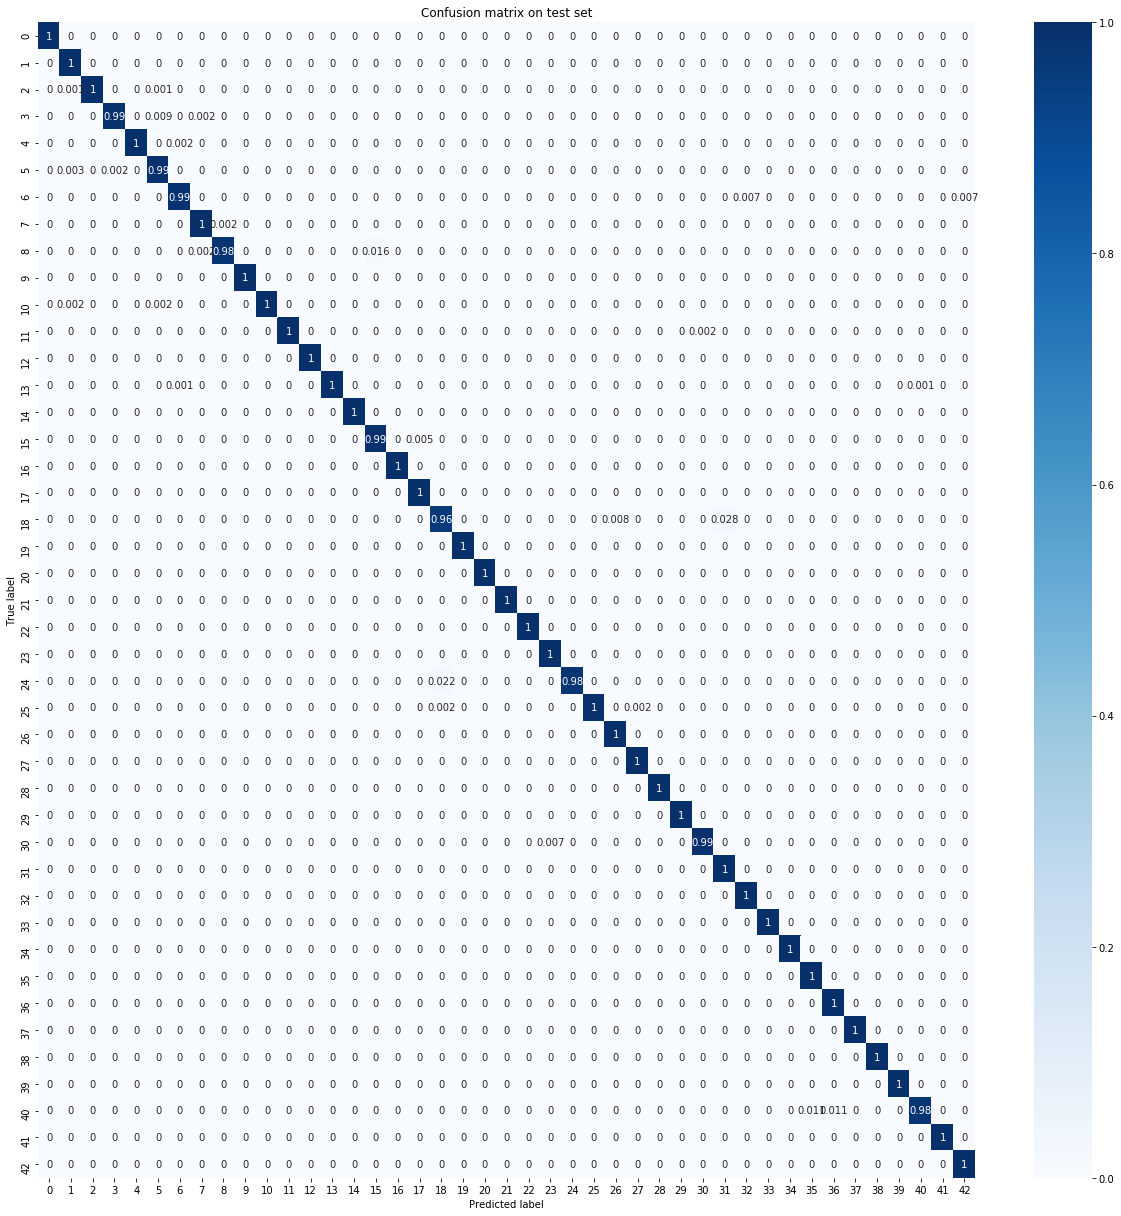

In [64]:
plot_confusion_matrix(Y_test, average_prediction(X_test), title="Confusion matrix on test set")

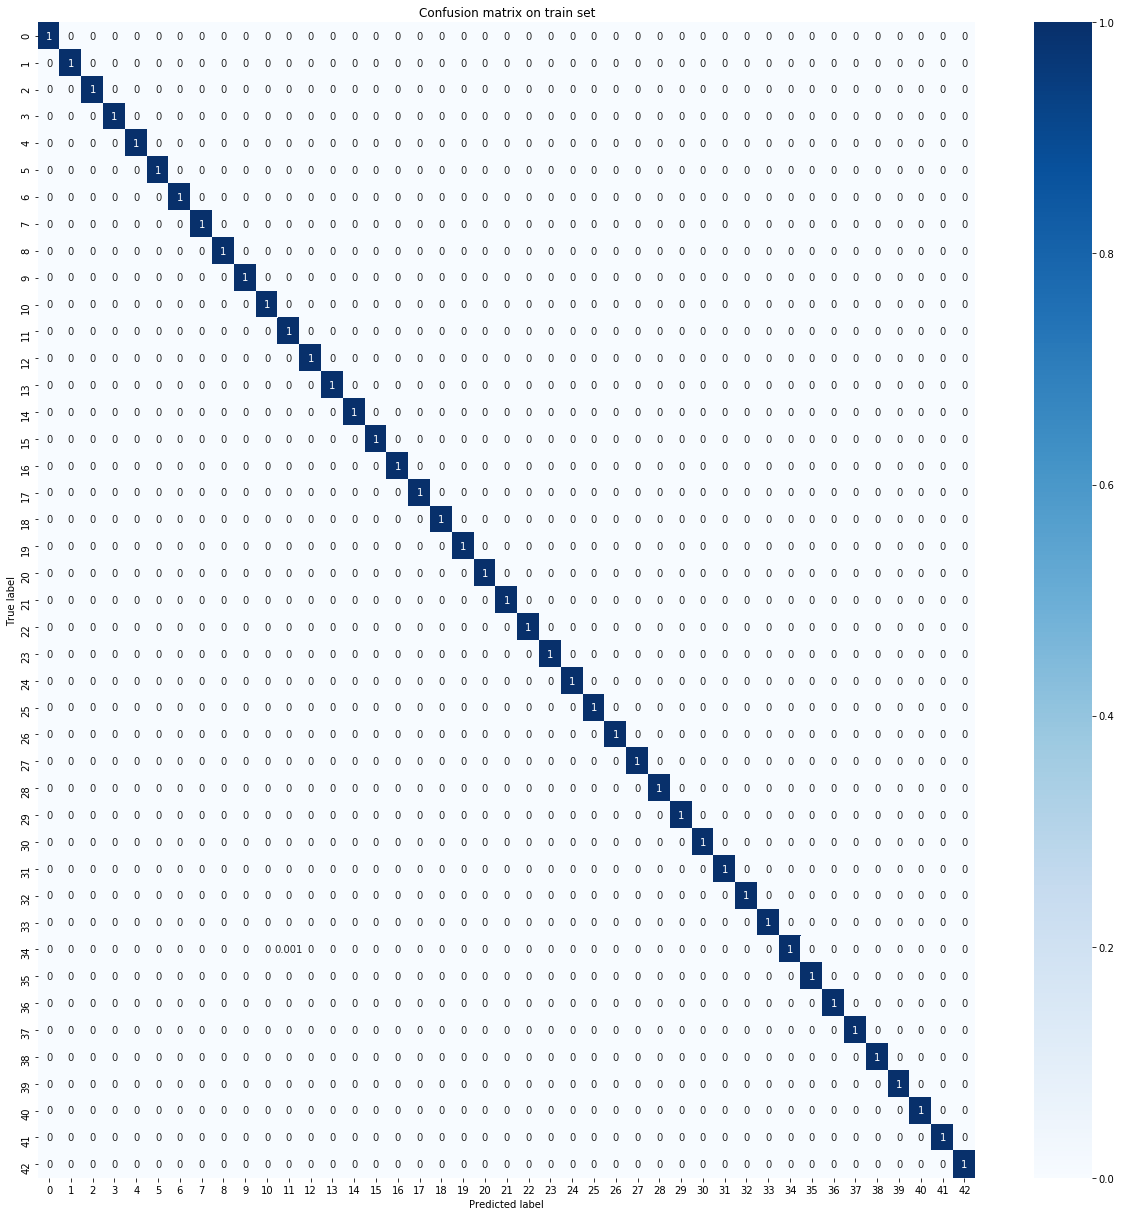

In [65]:
plot_confusion_matrix(Y_train, average_prediction(X_train), title="Confusion matrix on train set")

### Test the model using images from the web!

In [66]:
from utils.utils import predict_from_web

Predicted sign:  13    Yield


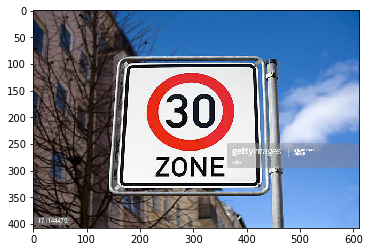

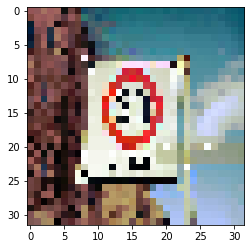

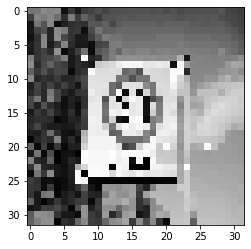

In [67]:
predict_from_web(
    'https://media.gettyimages.com/photos/german-traffic-sign-speed-limit-30-kilometers-per-hour-picture-id171144479?s=612x612',
    data, rgb_model, gray_model, foc_model)

It seems not performing good right?

Well the reason is that the model was trained on images where the traffic sign was taking most part of the image.

Let's see how it performs if we crop the image to center the traffic sign.

Predicted sign:  1    Speed limit (30km/h)


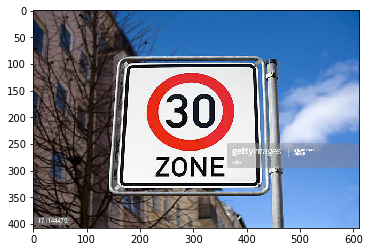

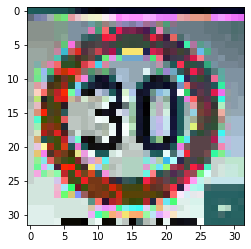

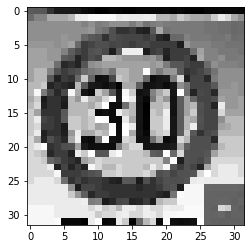

In [68]:
predict_from_web(
    'https://media.gettyimages.com/photos/german-traffic-sign-speed-limit-30-kilometers-per-hour-picture-id171144479?s=612x612',
    data, rgb_model, gray_model, foc_model, crop=(100, 280, 200, 400))

This make sense, if you want to have accurate predictions on real world images you will need a good region proposal network or some other techniques to crop the image to the ROI.

Predicted sign:  25    Road work


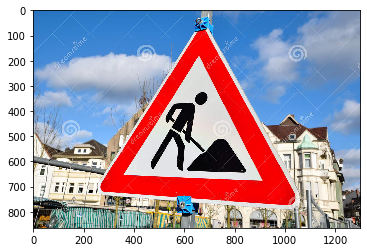

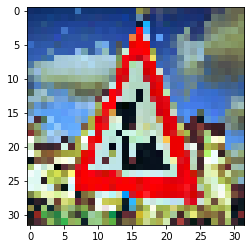

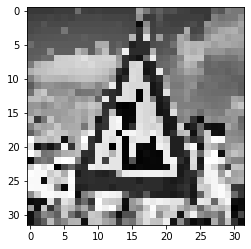

In [69]:
predict_from_web(
    'https://raw.githubusercontent.com/dhnkrn/Traffic-Sign-Classifier/master/images/german_1.jpg',
    data, rgb_model, gray_model, foc_model)